A prototype of the a K-D Tree approach using data points sampled uniformly from a unit square. We assume in this first iteration that $k=1$.

In [172]:
import matplotlib.pyplot as plt
import numpy as np

In [173]:
# Parameters
N = 1000
M = 1000
SEED = 1729

In [174]:
# True regression function
f = lambda x, y: x * y

In [175]:
# Generate data
#np.random.seed(SEED)
X_train = np.random.uniform(0, 1, size=(N, 2))
y_train = f(X_train[:, 0], X_train[:, 1])
X_test = np.random.uniform(0, 1, size=(M, 2))
y_test = f(X_train[:, 0], X_train[:, 1])

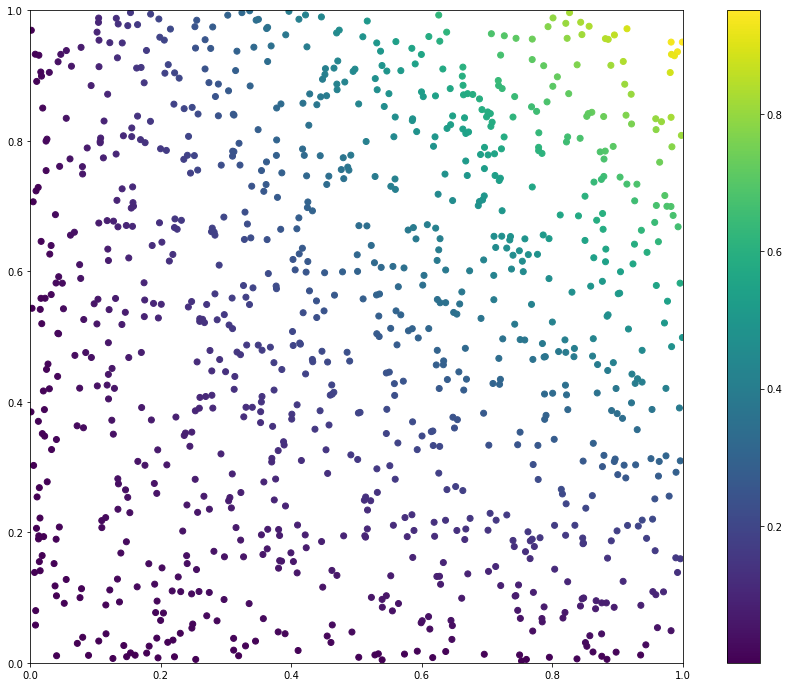

In [176]:
# Plot training data
fig, ax = plt.subplots(figsize=(16, 12))
scat = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
ax.set_aspect(1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.colorbar(scat)
plt.show()

In [177]:
class Node:
    
    def __init__(self, point, value, parent=None):
        self.point = point
        self.value = value
        self.parent = parent
    
    def assign_children(self, left, right):
        self.left = left
        self.right = right

# Todo: add max depth
def kd_tree(X, y):
    
    k = X.shape[1]
    
    def grow_tree(X_sub, y_sub, depth=0, parent=None):
        # Constants
        n = X_sub.shape[0]
        split = (n-1) // 2
        # Special case when no more points
        if not n:
            return None
        # Sort over target dimension
        dim = depth % k
        order = X_sub[:, dim].argsort()
        X_sort = X_sub[order]
        y_sort = y_sub[order]
        # Create node
        point = X_sort[split]
        value = y_sort[split]
        parent = Node(point, value, parent)
        # Recursion
        left = grow_tree(X_sort[:split], y_sort[:split],
                         depth + 1, parent)
        right = grow_tree(X_sort[(split + 1):], y_sort[(split + 1):],
                          depth + 1, parent)
        # Assign children
        parent.assign_children(left, right)
        
        return parent
    
    root = grow_tree(X, y)
    return root

root = kd_tree(X_train, y_train)

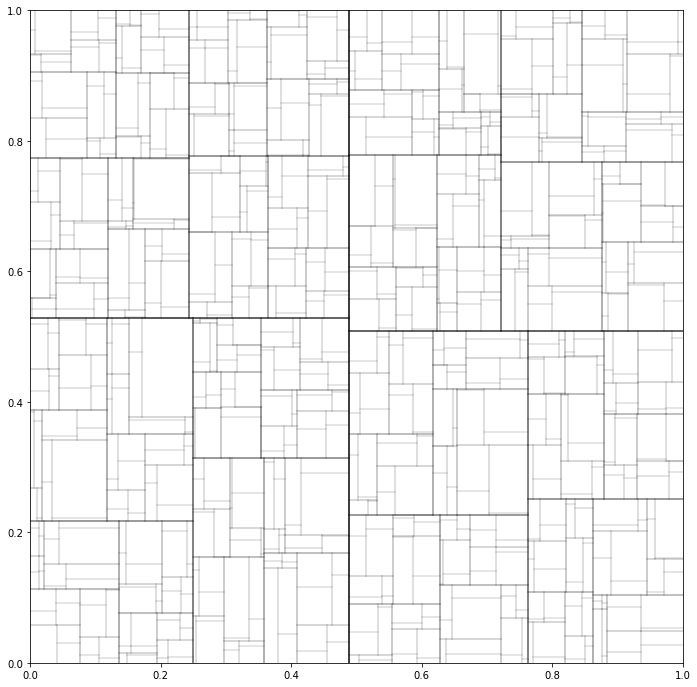

In [183]:
# Plot tree
def plot_2d_tree(root, ax, max_depth=None, fade_factor=1):
    
    def plot_split(node, ax, max_depth, depth=0,
                   side='left', region=np.array([0., 0., 1., 1.])):
        # Constants
        dim = depth % 2
        # Special cases
        if node is None:
            return
        if not max_depth is None and depth >= max_depth:
            return
        # Plot line
        method = 'axvline' if dim == 0 else 'axhline'
        getattr(ax, method)(node.point[dim],
                            region[1-dim],
                            region[2 + (1-dim)],
                            c='k', alpha=fade_factor ** depth)
        # Recursion
        left_region = region.copy()
        left_region[2 + dim] = node.point[dim]
        plot_split(node.left, ax, max_depth, depth + 1, 'left', left_region)
        right_region = region.copy()
        right_region[dim] = node.point[dim]
        plot_split(node.right, ax, max_depth, depth + 1, 'right', right_region)
    
    plot_split(root, ax, max_depth)

fig, ax = plt.subplots(figsize=(12, 12))
# scat = ax.scatter(X_train[:, 0], X_train[:, 1], c='red', alpha=0.2)
plot_2d_tree(root, ax, fade_factor=0.8)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect(1)
plt.show()

In [187]:
# Make predictions
def predict(root, X_test):
    
    def closest(n1, n2, x_test):
        # Special case
        if n1 is None: return n2, np.sum(np.square(n2.point - x_test))
        if n2 is None: return n1, np.sum(np.square(n1.point - x_test))
        # Compare distances
        d1 = np.sum(np.square(n1.point - x_test))
        d2 = np.sum(np.square(n2.point - x_test))
        return (n1, d1) if d1 < d2 else (n2, d2)
    
    def nearest_neighbour(node, x_test, depth=0):
        # Constants
        dim = depth % 2
        # Special case
        if node is None:
            return None
        # Recursion
        if x_test[dim] < node.point[dim]:
            target = node.left
            other = node.right
        else:
            target = node.right
            other = node.left
        target_candidate = nearest_neighbour(target, x_test, depth + 1)
        # Compare to current node
        candidate, r2 = closest(target_candidate, node, x_test)
        # Consider other branch
        d2 = np.square(node.point[dim] - x_test[dim])
        if r2 >= d2:
            other_candidate = nearest_neighbour(other, x_test, depth + 1)
            candidate, __ = closest(other_candidate, candidate, x_test)
        
        return candidate
    
    m = X_test.shape[0]
    preds = np.empty((m,))
    for i in range(m):
        preds[i] = nearest_neighbour(root, X_test[i]).value
    
    return preds

preds = predict(root, X_test)

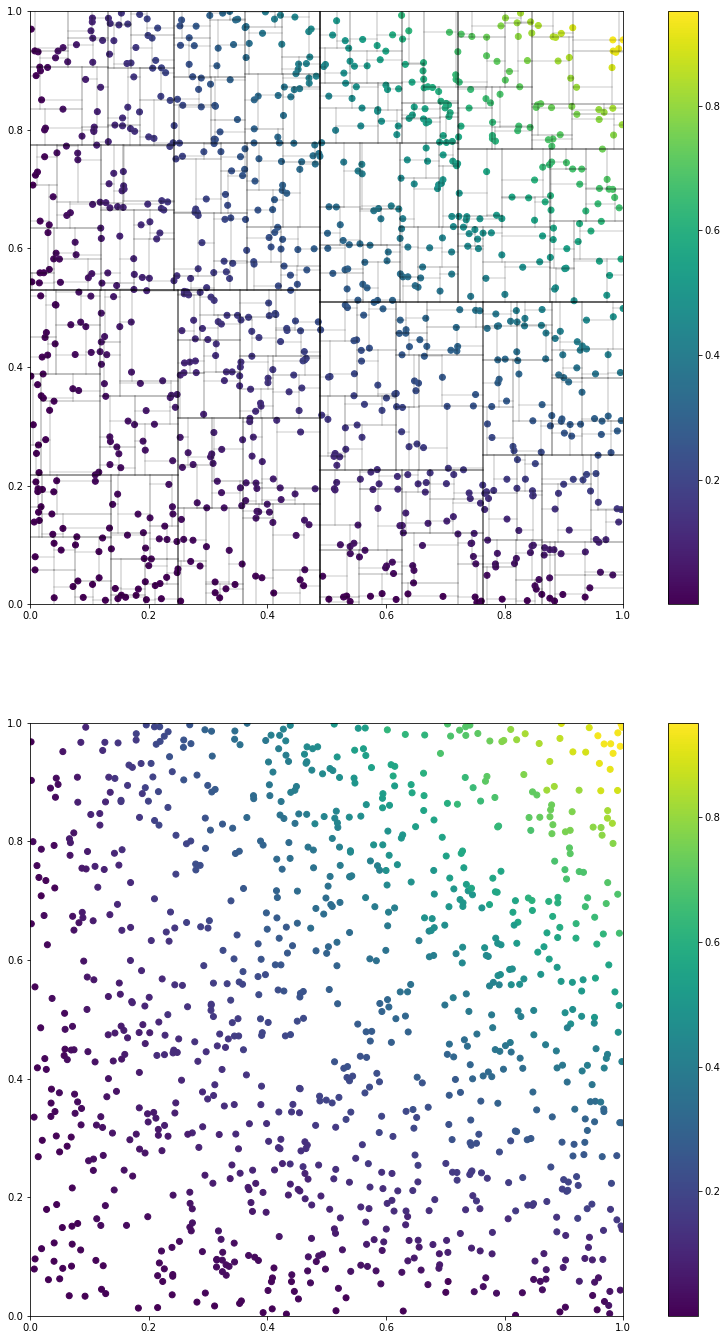

In [188]:
# Plot predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 24))
scat1 = ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plot_2d_tree(root, ax1, fade_factor=0.8)
scat2 = ax2.scatter(X_test[:, 0], X_test[:, 1], c=preds)
ax1.set_aspect(1)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.set_aspect(1)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
plt.colorbar(scat1, ax=ax1)
plt.colorbar(scat2, ax=ax2)
plt.show()

In [181]:
# Construct k-d tree
# class Node:
#     
#     def __init__(self, val, left, right):
#         self.val = val
#         self.left = left
#         self.right = right
#         self.parent = None
#     
#     def set_parent(self, parent):
#         self.parent = parent
# 
# def kd_tree(X, k=2):
#     
#     def kd_tree_recurse(X_sub, depth=0):
#         # Special cases
#         if not X_sub.shape[0]:
#             return None
#         if np.unique(X_sub, axis=0).shape[0] == 1:
#             return None
#         # Recursion
#         axis = depth % k
#         med = np.percentile(X_sub[:, axis], 50, interpolation='nearest')
#         node = Node(
#             med,
#             kd_tree_recurse(X_sub[X_sub[:, axis] <= med], depth + 1),
#             kd_tree_recurse(X_sub[X_sub[:, axis] > med], depth + 1)
#         )
#         return node
#     
#     def assign_parents(node):
#         if node.left is not None:
#             node.left.set_parent(node)
#             assign_parents(node.left)
#         if node.right is not None:
#             node.right.set_parent(node)
#             assign_parents(node.right)
#     
#     root = kd_tree_recurse(X)
#     assign_parents(root)
#     
#     return root
# 
# root = kd_tree(X_train)

**Todo:** should not be plotting to edge each time.

In [160]:
# Plot tree
# def plot_2d_tree(root, ax, max_depth=None, fade_factor=1):
#     
#     def plot_tree_recurse(node, ax, max_depth, depth=0, side=0, last_val=1):
#         # Special cases
#         if node is None:
#             return
#         if not max_depth is None and depth >= max_depth:
#             return
#         # Recursion
#         if depth == 0 or depth == 2:
#             ax.axvline(node.val, side, last_val,
#                        c='black', alpha = fade_factor ** depth)    
#         elif depth == 1:
#             ax.axhline(node.val, side, last_val,
#                        c='black', alpha = fade_factor ** depth)    
#         elif depth % 2 == 0:
#             ax.axvline(node.val, node.parent.parent.parent.val, last_val,
#                        c='black', alpha = fade_factor ** depth)
#         else:
#             ax.axhline(node.val, node.parent.parent.parent.val, last_val,
#                        c='black', alpha = fade_factor ** depth)
#         plot_tree_recurse(node.left, ax, max_depth, depth + 1,
#                           side=0, last_val=node.val)
#         plot_tree_recurse(node.right, ax, max_depth, depth + 1,
#                           side=1, last_val=node.val)
#     
#     plot_tree_recurse(root, ax, max_depth)
# 
# fig, ax = plt.subplots(figsize=(12, 12))
# scat = ax.scatter(X_train[:, 0], X_train[:, 1], c='red', alpha=0.2)
# plot_2d_tree(root, ax, fade_factor=0.8)
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_aspect(1)
# plt.show()